In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [ ]:
import pandas as pd

In [ ]:
# for Ethan's drive configuration
label_df = pd.read_csv('/content/First999Labels_with_clean.csv')

In [ ]:
# for Saloni's drive configuration
label_df = pd.read_csv('/content/drive/MyDrive/content/First999Labels_with_clean.csv')

In [ ]:
# Map labels to integers
label_mapping = {1: 0, 2: 1, 3: 2}
label_df['majority_vote'] = label_df['majority_vote'].map(label_mapping)

In [ ]:
# Tokenization
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the data
def tokenize_function(text):
    return tokenizer(text, padding='max_length', truncation=True, max_length=128)

label_df['tokenized'] = label_df['clean'].apply(tokenize_function)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
import torch

In [ ]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the dataset
train_texts, temp_texts, train_labels, temp_labels = train_test_split(label_df['tokenized'].to_list(), label_df['majority_vote'].to_list(), test_size=0.3, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [ ]:
def convert_to_dicts(tokenized_texts):
    input_ids = [d['input_ids'] for d in tokenized_texts]
    attention_masks = [d['attention_mask'] for d in tokenized_texts]
    return {'input_ids': input_ids, 'attention_mask': attention_masks}

In [ ]:
# Convert to lists of dictionaries
train_encodings = convert_to_dicts(train_texts)
val_encodings = convert_to_dicts(val_texts)
test_encodings = convert_to_dicts(test_texts)

In [ ]:
# Create three dataset objects using the SentimentDataset
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [ ]:
# from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

In [ ]:
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
# training_args = TrainingArguments(
#     output_dir='./results',
#     num_train_epochs=3,
#     per_device_train_batch_size=16,  # Increased if GPU memory allows
#     per_device_eval_batch_size=16,
#     warmup_steps=100,  # Increased for better warmup
#     weight_decay=0.01,
#     logging_dir='./logs',
#     # max_steps=10,  # Comment out or remove to allow full training
#     save_steps=100,
#     logging_steps=50,
#     eval_strategy="epoch",  # Add evaluation after each epoch
#     save_strategy="epoch",
#     load_best_model_at_end=True,
# )
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Can keep 3 epochs since model is faster
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=50,
    weight_decay=0.01,
    logging_dir='./logs',
    save_steps=500,
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
)

In [ ]:
trainer = Trainer(
    model=model, # The pre-trained model that you want to fine-tune or train
    args=training_args, # The training arguments that specify the configurations for the training process
    train_dataset=train_dataset, # The dataset used for training the model
    eval_dataset=val_dataset # The dataset used for evaluating the model during training
)


In [ ]:
# Start training
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: saloni-agshiker (saloni-agshiker-georgia-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,No log,0.694484
2,No log,0.613174
3,No log,0.664741


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=66, training_loss=0.7886468135949337, metrics={'train_runtime': 1834.7576, 'train_samples_per_second': 1.145, 'train_steps_per_second': 0.036, 'total_flos': 69546624537600.0, 'train_loss': 0.7886468135949337, 'epoch': 3.0})

In [ ]:
# Evaluate the Model
results = trainer.evaluate(test_dataset)

print("Evaluation Results:")
print(f"  - Loss: {results['eval_loss']:.4f}")
print(f"  - Runtime: {results['eval_runtime']:.2f} seconds")
print(f"  - Samples per Second: {results['eval_samples_per_second']:.2f}")
print(f"  - Steps per Second: {results['eval_steps_per_second']:.2f}")
print(f"  - Epoch: {results['epoch']:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation Results:
  - Loss: 0.8175
  - Runtime: 38.77 seconds
  - Samples per Second: 3.87
  - Steps per Second: 0.08
  - Epoch: 3.0000


In [ ]:
# Save the model and tokenizer in the current folder
model_save_path = "./"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [ ]:
def predict_sentiment(text):
    '''Function to predict the sentiment of a given text using a pre-trained BERT model.
    Args: the input text for sentiment prediction.
    Returns: the predicted sentiment ('negative', 'neutral', 'positive').
    '''

    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(predictions, dim=1).item()
    sentiment = {0: 'negative', 1: 'neutral', 2: 'positive'}
    return sentiment[predicted_class]

Predicted Sentiment: positive


In [ ]:
# Example prediction
example_text = "Wow, I am so impressed!"
predicted_sentiment = predict_sentiment(example_text)
print(f"Predicted Sentiment: {predicted_sentiment}")

Predicted Sentiment: positive


In [ ]:
# Saloni's code to run Harikesh's dataset
from tqdm import tqdm

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/content/forum_posts_with_grades.csv")

In [ ]:
# apply the prediction to all rows
tqdm.pandas()   # shows a progress bar

df["sentiment"] = df["body"].progress_apply(predict_sentiment)

# save the updated file
df.to_csv("/content/drive/MyDrive/content/output_with_sentiment.csv", index=False)

In [ ]:
df.to_csv("/content/drive/MyDrive/content/output_with_sentiment.csv", index=False)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Confusion Matrix:
 [[ 0 21  0]
 [ 0 94  5]
 [ 0 19 11]]

Classification Report:
               precision    recall  f1-score   support

    negative       0.00      0.00      0.00        21
     neutral       0.70      0.95      0.81        99
    positive       0.69      0.37      0.48        30

    accuracy                           0.70       150
   macro avg       0.46      0.44      0.43       150
weighted avg       0.60      0.70      0.63       150



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


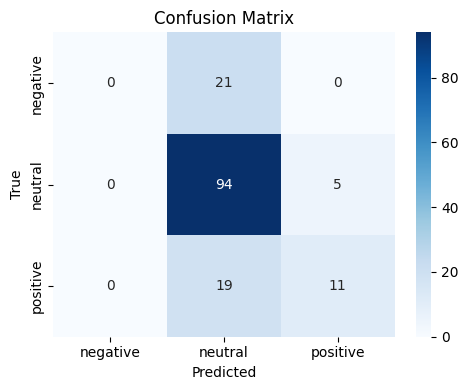

In [ ]:
# Get predictions
pred_output = trainer.predict(test_dataset)
pred_labels = pred_output.predictions.argmax(axis=1)
true_labels = pred_output.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=['negative','neutral','positive']))

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative','neutral','positive'],
            yticklabels=['negative','neutral','positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()